In [2]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

%matplotlib inline

random_state = 42
np.random.seed(random_state)


In [3]:
data = pd.read_pickle("data_forecast.pickle")

data.head()
# not sure why LR is totally wrong

,index,DATETIME,SYMBOL,PERMNO,INDUSTRY,VALUE,MOMENTUM,MONETARYPOLICY,GROWTH,INFLATION,...,SP500TR,RELRET,RELRET3,LR,XGB,RF,LASSO,RIDGE,MLP,EL
0,325,1963-01-31,ACF,10006,25,1.443624,0.126256,0.99,99.788054,0.012821,...,0.049128,-0.002126,0.017905,5.043180e+06,-0.068489,-0.020510,-1.569046,-0.995038,1.605303,-0.797462
1,729,1963-02-28,ACF,10006,25,1.443624,0.096012,0.92,99.939763,0.009615,...,-0.028852,0.067552,0.057131,5.043180e+06,-0.035485,-0.003072,-1.571886,-0.996925,1.606043,-0.798989
2,1137,1963-03-31,ACF,10006,25,1.443624,0.133934,1.00,100.074720,0.012821,...,0.035464,-0.044473,0.066778,5.043180e+06,-0.068527,-0.041312,-1.573601,-0.997955,1.610703,-0.799816
3,1553,1963-04-30,ACF,10006,25,1.443624,0.268752,1.04,100.184328,0.012780,...,0.048520,0.036328,0.137539,5.043180e+06,-0.063821,-0.029752,-1.574595,-0.998576,1.615610,-0.800336
4,1957,1963-05-31,ACF,10006,25,1.443624,0.189535,1.07,100.262197,0.012780,...,0.014327,0.077293,0.051890,5.043180e+06,-0.071962,-0.039860,-1.576117,-0.999514,1.616433,-0.801076


In [4]:
# get unique dates
# function to take a dataframe, date, column
#   compute quantile for that date, update quantile column, return dataframe
# loop through dates, call function, accumulate dfs in list, concat

# for each quantile
#   use .loc to select rows in that bucket
#   group by date and average performance by date
#   save performance as a series
# plot 10 series

uniquedates = sorted(data["DATETIME"].unique())
uniquedates

[numpy.datetime64('1963-01-31T00:00:00.000000000'),
 numpy.datetime64('1963-02-28T00:00:00.000000000'),
 numpy.datetime64('1963-03-31T00:00:00.000000000'),
 numpy.datetime64('1963-04-30T00:00:00.000000000'),
 numpy.datetime64('1963-05-31T00:00:00.000000000'),
 numpy.datetime64('1963-06-30T00:00:00.000000000'),
 numpy.datetime64('1963-07-31T00:00:00.000000000'),
 numpy.datetime64('1963-08-31T00:00:00.000000000'),
 numpy.datetime64('1963-09-30T00:00:00.000000000'),
 numpy.datetime64('1963-10-31T00:00:00.000000000'),
 numpy.datetime64('1963-11-30T00:00:00.000000000'),
 numpy.datetime64('1963-12-31T00:00:00.000000000'),
 numpy.datetime64('1964-01-31T00:00:00.000000000'),
 numpy.datetime64('1964-02-29T00:00:00.000000000'),
 numpy.datetime64('1964-03-31T00:00:00.000000000'),
 numpy.datetime64('1964-04-30T00:00:00.000000000'),
 numpy.datetime64('1964-05-31T00:00:00.000000000'),
 numpy.datetime64('1964-06-30T00:00:00.000000000'),
 numpy.datetime64('1964-07-31T00:00:00.000000000'),
 numpy.datet

In [5]:
num_buckets = 5

def bucket_df_by_col(df, col):
    # compute decile buckets for df.col
    # assign new column col_RANK containing decile bucket for each row
    newcol = col + "_RANK"
    vals = pd.qcut(df[col], num_buckets, labels=False)
    df[newcol] = vals
    #df = df.assign(c=col.values)
    return df


In [6]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "MOMENTUM") for d in uniquedates]
datanew= pd.concat(dflist)
datanew

/home/druce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,index,DATETIME,SYMBOL,PERMNO,INDUSTRY,VALUE,MOMENTUM,MONETARYPOLICY,GROWTH,INFLATION,...,RELRET,RELRET3,LR,XGB,RF,LASSO,RIDGE,MLP,EL,MOMENTUM_RANK
0,325,1963-01-31,ACF,10006,25,1.443624,0.126256,0.99,99.788054,0.012821,...,-0.002126,0.017905,5.043180e+06,-0.068489,-0.020510,-1.569046,-0.995038,1.605303,-0.797462,4
630,198,1963-01-31,AN,10102,14,0.795584,-0.106268,0.99,99.788054,0.012821,...,-0.007653,0.028508,2.634472e+07,-0.064930,-0.040381,-1.573840,-0.998733,1.600826,-0.800356,2
1909,129,1963-01-31,AYE,10137,31,0.519467,0.008584,0.99,99.788054,0.012821,...,0.004718,-0.020750,4.372594e+07,-0.063124,-0.047509,-1.575778,-1.000423,1.599042,-0.801620,4
2841,35,1963-01-31,HON,10145,41,0.649213,-0.191882,0.99,99.788054,0.012821,...,-0.023704,-0.024146,2.509495e+07,-0.068332,-0.106096,-1.575078,-0.999765,1.589538,-0.801147,1
3786,302,1963-01-31,AH,10153,21,2.372537,-0.208709,0.99,99.788054,0.012821,...,0.113265,0.013149,2.737134e+07,-0.062791,-0.018887,-1.565316,-0.992393,1.605184,-0.795384,1
3968,132,1963-01-31,AMX,10161,28,0.579169,-0.150678,0.99,99.788054,0.012821,...,0.075872,0.077785,1.614922e+07,-0.068332,0.004643,-1.575285,-0.999463,1.607677,-0.800900,1
4666,69,1963-01-31,BEAM,10225,17,0.625877,-0.368981,0.99,99.788054,0.012821,...,-0.006575,-0.004395,2.101274e+07,-0.067610,-0.078030,-1.576044,-1.000398,1.582752,-0.801632,0
5280,276,1963-01-31,ABC,10233,32,0.900164,-0.214792,0.99,99.788054,0.012821,...,0.017048,-0.068954,2.537750e+07,-0.068796,-0.043077,-1.573753,-0.997850,1.596653,-0.799615,1
5555,71,1963-01-31,PA,10241,39,0.756432,0.007215,0.99,99.788054,0.012821,...,-0.016341,-0.068515,1.251257e+07,-0.064238,-0.086271,-1.573530,-0.998646,1.595760,-0.800290,4
6519,190,1963-01-31,AMO,10321,23,0.925821,0.062629,0.99,99.788054,0.012821,...,0.189334,0.145074,2.190346e+07,-0.068013,-0.019711,-1.572632,-0.998337,1.594643,-0.800062,4


,Label,Annualized return,Annualized volatility
0,Quintile 0,7.245186,0.214921
1,Quintile 1,10.803440,0.164157
2,Quintile 2,11.510694,0.151248
3,Quintile 3,12.717732,0.156348
4,Quintile 4,17.253062,0.199979


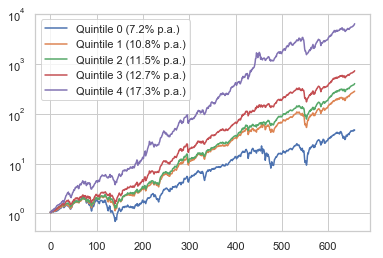

In [7]:
# performance by bucket
def perf_by_bucket(df, col, rank, perfcol="RET"):
    perf = df.loc[df[col]==rank][["DATETIME", col, perfcol]]\
        .groupby("DATETIME")\
        .mean()\
        .reset_index()
    return perf

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    tempdf = perf_by_bucket(datanew, "MOMENTUM_RANK", i)
    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET"].std() * np.sqrt(12)

    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)

/home/druce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Label,Annualized return,Annualized volatility
0,Quintile 0,10.969187,0.366098
1,Quintile 1,11.529971,0.311753
2,Quintile 2,12.210132,0.288019
3,Quintile 3,12.253167,0.283598
4,Quintile 4,12.870829,0.295841


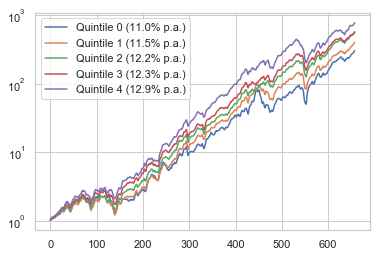

In [8]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "XGB") for d in uniquedates]
datanew= pd.concat(dflist)

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    
    tempdf = perf_by_bucket(datanew, "XGB_RANK", i, perfcol="RET3")
    # 1-month signal
    #tempdf["RET1P"] = 1 + tempdf["RET"]
    #tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    # we predicted 3-month returns
    # above we used momentum as a 1-month signal, buy quintile forecast each month
    # to put 1/3 of portfolio into a bucket and hold for 3 months we do
    tempdf["RET3P"] = (1 + tempdf["RET3"] / 3)
    tempdf["CUMPERF"] = tempdf["RET3P"].cumprod()
    
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET3"].std() * np.sqrt(12)

    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)


/home/druce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Label,Annualized return,Annualized volatility
0,Quintile 0,11.985577,0.345470
1,Quintile 1,11.820002,0.298816
2,Quintile 2,12.064190,0.289385
3,Quintile 3,11.766739,0.286416
4,Quintile 4,12.260672,0.290568


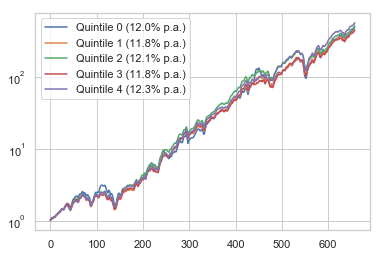

In [9]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "RF") for d in uniquedates]
datanew= pd.concat(dflist)

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    
    tempdf = perf_by_bucket(datanew, "RF_RANK", i, perfcol="RET3")
    # 1-month signal
    #tempdf["RET1P"] = 1 + tempdf["RET"]
    #tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    # we predicted 3-month returns
    # above we used as a 1-month signal, hold highest forecast each month
    # to put 1/3 of portfolio into a bucket and hold for 3 months do
    tempdf["RET3P"] = (1 + tempdf["RET3"] / 3)
    tempdf["CUMPERF"] = tempdf["RET3P"].cumprod()
    
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET3"].std() * np.sqrt(12)

    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)


/home/druce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Label,Annualized return,Annualized volatility
0,Quintile 0,9.845545,0.333743
1,Quintile 1,11.205252,0.321542
2,Quintile 2,12.559813,0.311123
3,Quintile 3,12.705802,0.263938
4,Quintile 4,13.557547,0.295475


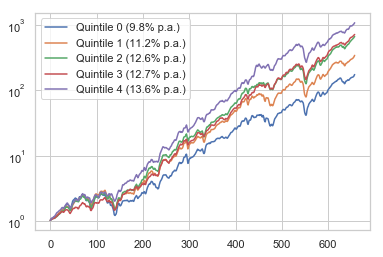

In [10]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "MLP") for d in uniquedates]
datanew= pd.concat(dflist)

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    
    tempdf = perf_by_bucket(datanew, "MLP_RANK", i, perfcol="RET3")
    # 1-month signal
    #tempdf["RET1P"] = 1 + tempdf["RET"]
    #tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    # we predicted 3-month returns
    # above we used as a 1-month signal, hold highest forecast each month
    # to put 1/3 of portfolio into a bucket and hold for 3 months do
    tempdf["RET3P"] = (1 + tempdf["RET3"] / 3)
    tempdf["CUMPERF"] = tempdf["RET3P"].cumprod()
    
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET3"].std() * np.sqrt(12)

    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)
plt.legend();

pd.DataFrame(reportdict)


/home/druce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Label,Annualized return,Annualized volatility
0,Quintile 0,7.009133,0.352001
1,Quintile 1,10.639512,0.299632
2,Quintile 2,12.494060,0.283174
3,Quintile 3,13.533307,0.280549
4,Quintile 4,16.310049,0.324939


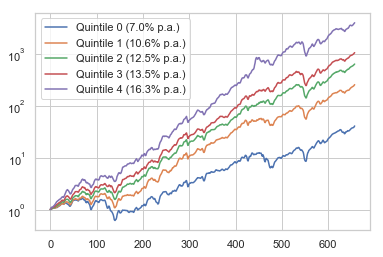

In [11]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "LASSO") for d in uniquedates]
datanew= pd.concat(dflist)

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    
    tempdf = perf_by_bucket(datanew, "LASSO_RANK", i, perfcol="RET3")
    # 1-month signal
    #tempdf["RET1P"] = 1 + tempdf["RET"]
    #tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    # we predicted 3-month returns
    # above we used as a 1-month signal, hold highest forecast each month
    # to put 1/3 of portfolio into a bucket and hold for 3 months do
    tempdf["RET3P"] = (1 + tempdf["RET3"] / 3)
    tempdf["CUMPERF"] = tempdf["RET3P"].cumprod()
    
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET3"].std() * np.sqrt(12)

    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)
    
plt.legend();

pd.DataFrame(reportdict)


/home/druce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Label,Annualized return,Annualized volatility
0,Quintile 0,6.819116,0.344462
1,Quintile 1,10.625851,0.299277
2,Quintile 2,12.250133,0.282662
3,Quintile 3,13.898475,0.283506
4,Quintile 4,16.439011,0.324165


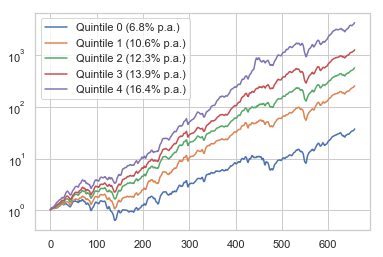

In [12]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "RIDGE") for d in uniquedates]
datanew= pd.concat(dflist)

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    
    tempdf = perf_by_bucket(datanew, "RIDGE_RANK", i, perfcol="RET3")
    # 1-month signal
    #tempdf["RET1P"] = 1 + tempdf["RET"]
    #tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    # we predicted 3-month returns
    # above we used as a 1-month signal, hold highest forecast each month
    # to put 1/3 of portfolio into a bucket and hold for 3 months do
    tempdf["RET3P"] = (1 + tempdf["RET3"] / 3)
    tempdf["CUMPERF"] = tempdf["RET3P"].cumprod()
    
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET3"].std() * np.sqrt(12)

    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)
    
plt.legend();

pd.DataFrame(reportdict)


/home/druce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Label,Annualized return,Annualized volatility
0,Quintile 0,6.846029,0.343869
1,Quintile 1,10.678889,0.300662
2,Quintile 2,12.266068,0.283464
3,Quintile 3,13.804236,0.282325
4,Quintile 4,16.439395,0.322569


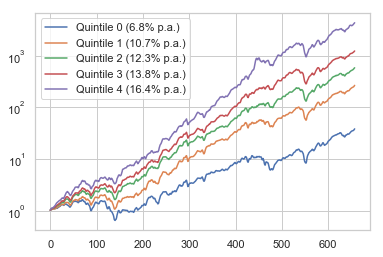

In [13]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "EL") for d in uniquedates]
datanew= pd.concat(dflist)

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    
    tempdf = perf_by_bucket(datanew, "EL_RANK", i, perfcol="RET3")
    # 1-month signal
    #tempdf["RET1P"] = 1 + tempdf["RET"]
    #tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    # we predicted 3-month returns
    # above we used as a 1-month signal, hold highest forecast each month
    # to put 1/3 of portfolio into a bucket and hold for 3 months do
    tempdf["RET3P"] = (1 + tempdf["RET3"] / 3)
    tempdf["CUMPERF"] = tempdf["RET3P"].cumprod()
    
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET3"].std() * np.sqrt(12)

    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)
    
plt.legend();

pd.DataFrame(reportdict)


In [14]:
# very crude beta adjustment - 17.25% equiv of 13.05% if you bring risk down to median
0.151248 / 0.199979 * 17.253062

13.048825733582026

In [15]:
IBM = datanew.loc[datanew['SYMBOL']=="IBM"]
IBM[["DATETIME", "RET", "MOMENTUM"]].tail(100)

,DATETIME,RET,MOMENTUM
37861,2009-07-31,0.129381,-0.084515
37862,2009-08-31,0.005681,-0.166953
37863,2009-09-30,0.013215,-0.014913
37864,2009-10-31,0.008361,0.031087
37865,2009-11-30,0.052152,0.314290
37866,2009-12-31,0.036011,0.500744
37867,2010-01-31,-0.065011,0.530980
37868,2010-02-28,0.043468,0.456488
37869,2010-03-31,0.008572,0.348849
37870,2010-04-30,0.005848,0.336881
